# binary classification example - titanic dataset

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import copy
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import treelite
import treelite_runtime
import dill
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

cmap = sns.color_palette("vlag", as_cmap=True)

**Gators** imports

In [5]:
# data cleaning
from gators.data_cleaning import (
    DropColumns,
    Replace,
)

# imputers
from gators.imputers import (
    NumericImputer,
    ObjectImputer,
)

# encoders
from gators.encoders import (
    WOEEncoder,
    TargetEncoder,
)

# binning
from gators.binning import (
    BinRareCategories,
    BinSingleTargetClassCategories,
    Binning,
    TreeBinning,
)

# feature generation
from gators.feature_generation import (
    ElementaryArithmetics,
    PolynomialObjectFeatures,
    IsNull,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    SplitExtract,
)

# feature selection
from gators.feature_selection import InformationValue

# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
)

# pipeline
from gators.pipeline import Pipeline

In [6]:
data = pd.read_parquet("data/titanic.parquet")
data = data.reset_index(drop=True)
y = data["Survived"]
X = data.drop("Survived", axis=1)
train_test_split = TrainTestSplit(test_ratio=0.3, strategy="stratified")
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

## data analysis

In [7]:
X_train.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
614,3,"Brocklebank, Mr. William Alfred",male,35.0,0,0,364512,8.0500,None,S
138,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,None,S


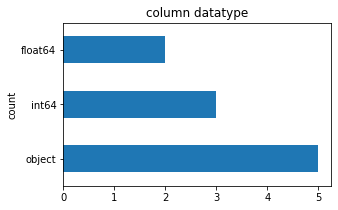

In [8]:
X_train.dtypes.value_counts().plot(
    figsize=(3 * 1.6, 3),
    kind="barh",
    title="column datatype",
    ylabel="dtype",
    xlabel="count",
);

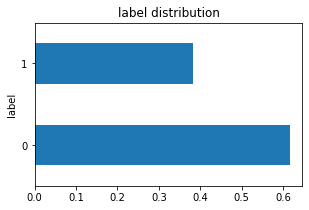

In [9]:
label_counts = data["Survived"].value_counts(normalize=True).sort_values().iloc[::-1]
label_counts.plot(
    kind="barh",
    figsize=(3 * 1.6, 3),
    title="label distribution",
    xlabel="label",
);

In [10]:
steps = [
    ("StringLength", StringLength(columns=["Ticket"])),
    ("SplitExtractName", SplitExtract(["Name"], [", "], [1], ["Dummy"])),
    ("SplitExtractTitle", SplitExtract(["Dummy"], ["."], [0], ["Title"])),
    ("IsNull", IsNull(columns=["Age", "Cabin"])),
    ("DropColumns", DropColumns(["Name", "Dummy", "Cabin", "Ticket"])),
    ("ObjectImputer", ObjectImputer(strategy="constant", value="MISSING")),
    ("BinSingleTargetClassCategories", BinSingleTargetClassCategories()),
    ("NumericImputer", NumericImputer(strategy="mean")),
    (
        "ElementaryArithmetics",
        ElementaryArithmetics(
            operator="+",
            columns_a=["SibSp"],
            columns_b=["Parch"],
            column_names=["FamilySize"],
        ),
    ),
    (
        "TreeBinning",
        TreeBinning(
            tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120), inplace=True
        ),
    ),
    (
        "Replace",
        Replace(
            to_replace_dict={
                "Cabin__is_null": {"(-inf, 0.5)": "false", "[0.5, inf)": "true"},
                "Age__is_null": {"(-inf, 0.5)": "false", "[0.5, inf)": "true"},
                "Fare": {
                    "(-inf, 10.48)": "EconomicFare",
                    "[10.48, 19.73)": "EconomicPlusFare",
                    "[19.73, 35.25)": "BussinessFare",
                    "[35.25, inf)": "FirstClassFare",
                },
                "Pclass": {
                    "(-inf, 1.5)": "1stClass",
                    "[1.5, 2.5)": "2ndClass",
                    "[2.5, inf)": "3rdClass",
                },
                "Sex": {"female": "Woman", "male": "Man"},
                "FamilySize": {"(-inf, 0.5)": "NoFamily", "[1.5, inf)": "WithFamily"},
                "Age": {
                    "(-inf, 27.5)": "Young",
                    "[27.5, 30.25)": "Adult",
                    "[30.25, inf)": "Senior",
                },
            }
        ),
    ),
    ("Encoder", TargetEncoder()),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)

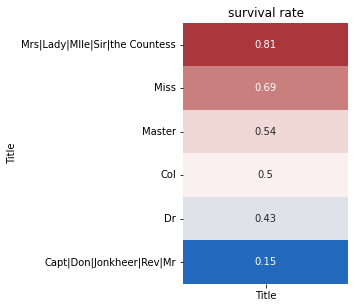

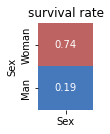

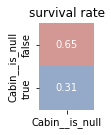

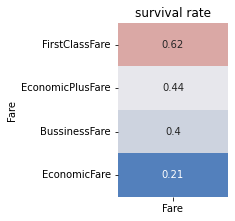

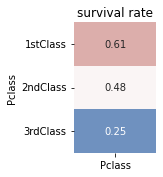

In [11]:
pipe.steps[-1][1].display_mapping(cmap="vlag", title="survival rate")

### adding polynomial object features

In [12]:
steps = [
    ("StringLength", StringLength(columns=["Ticket"])),
    ("SplitExtractName", SplitExtract(["Name"], [", "], [1], ["Dummy"])),
    ("SplitExtractTitle", SplitExtract(["Dummy"], ["."], [0], ["Title"])),
    ("IsNull", IsNull(columns=["Age", "Cabin"])),
    ("DropColumns", DropColumns(["Name", "Dummy", "Cabin", "Ticket"])),
    ("ObjectImputer", ObjectImputer(strategy="constant", value="MISSING")),
    ("BinSingleTargetClassCategories", BinSingleTargetClassCategories()),
    ("NumericImputer", NumericImputer(strategy="mean")),
    (
        "ElementaryArithmetics",
        ElementaryArithmetics(
            operator="+",
            columns_a=["SibSp"],
            columns_b=["Parch"],
            column_names=["FamilySize"],
        ),
    ),
    (
        "TreeBinning",
        TreeBinning(
            tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120), inplace=True
        ),
    ),
    (
        "Replace",
        Replace(
            to_replace_dict={
                "Cabin__is_null": {"(-inf, 0.5)": "false", "[0.5, inf)": "true"},
                "Age__is_null": {"(-inf, 0.5)": "false", "[0.5, inf)": "true"},
                "Fare": {
                    "(-inf, 10.48)": "EconomicFare",
                    "[10.48, 19.73)": "EconomicPlusFare",
                    "[19.73, 35.25)": "BussinessFare",
                    "[35.25, inf)": "FirstClassFare",
                },
                "Pclass": {
                    "(-inf, 1.5)": "1stClass",
                    "[1.5, 2.5)": "2ndClass",
                    "[2.5, inf)": "3rdClass",
                },
                "Sex": {"female": "Woman", "male": "Man"},
                "FamilySize": {"(-inf, 0.5)": "NoFamily", "[1.5, inf)": "WithFamily"},
                "Age": {
                    "(-inf, 27.5)": "Young",
                    "[27.5, 30.75)": "Adult",
                    "[30.75, inf)": "Senior",
                },
            }
        ),
    ),
    (
        "PolynomialObjectFeatures",
        PolynomialObjectFeatures(
            columns=["Pclass", "Sex", "Age", "Fare", "Embarked", "Title", "FamilySize"],
            degree=2,
        ),
    ),
    ("DropPolynomialColumns", DropColumns(columns=["Sex__x__Title"])),
    ("CleanCategories", BinRareCategories(min_ratio=0.1)),
    ("Encoder", TargetEncoder()),
]
pipe = Pipeline(steps=steps)
_ = pipe.fit(X_train.copy(), y_train)

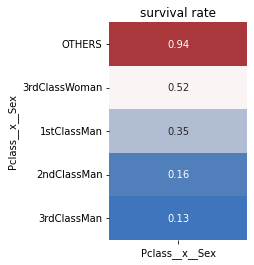

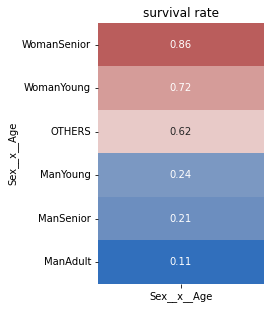

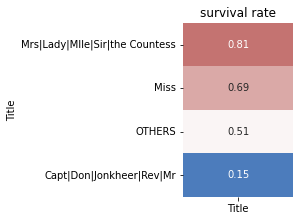

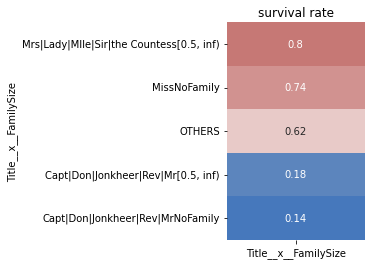

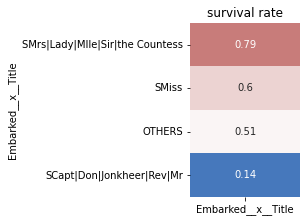

In [13]:
pipe.steps[-1][1].display_mapping(cmap="vlag", title="survival rate")

## offline pipeline - feature selection

In [14]:
k = 12
model = XGBClassifier(
    random_state=0,
    eval_metric="logloss",
)
offline_steps = [
    ("StringLength", StringLength(columns=["Ticket"])),
    ("SplitExtractName", SplitExtract(["Name"], [", "], [1], ["Dummy"])),
    ("SplitExtractTitle", SplitExtract(["Dummy"], ["."], [0], ["Title"])),
    ("IsNull", IsNull(columns=["Age", "Cabin"])),
    ("DropColumns", DropColumns(["Name", "Dummy", "Cabin", "Ticket"])),
    ("ObjectImputer", ObjectImputer(strategy="constant", value="MISSING")),
    ("BinSingleTargetClassCategories", BinSingleTargetClassCategories()),
    ("NumericImputer", NumericImputer(strategy="mean")),
    (
        "ElementaryArithmetics",
        ElementaryArithmetics(
            operator="+",
            columns_a=["SibSp"],
            columns_b=["Parch"],
            column_names=["FamilySize"],
        ),
    ),
    (
        "TreeBinning",
        TreeBinning(
            tree=DecisionTreeClassifier(max_depth=3, min_samples_leaf=120), inplace=True
        ),
    ),
    ("CleanCategories", BinRareCategories(min_ratio=0.0)),
    ("InformationValue", InformationValue(k=k)),
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train.copy(), y_train)
features = list(X_train_prepro.columns)

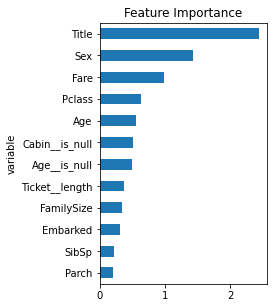

In [15]:
offline_pipe.steps[-1][1].feature_importances_.iloc[::-1].plot(
    kind="barh",
    figsize=(3, 3 * 1.6),
    title="Feature Importance",
);

All the features will be used.

## pipeline optimization

In [16]:
steps = [
    ("StringLength", StringLength(columns=["Ticket"])),
    ("SplitExtractName", SplitExtract(["Name"], [", "], [1], ["Dummy"])),
    ("SplitExtractTitle", SplitExtract(["Dummy"], ["."], [0], ["Title"])),
    ("IsNull", IsNull(columns=["Age", "Cabin"])),
    ("DropColumns", DropColumns(["Name", "Dummy", "Cabin", "Ticket"])),
    ("ObjectImputer", ObjectImputer(strategy="constant", value="MISSING")),
    ("BinSingleTargetClassCategories", BinSingleTargetClassCategories()),
    ("NumericImputer", NumericImputer(strategy="mean", value=-1)),
    (
        "ElementaryArithmetics",
        ElementaryArithmetics(
            operator="+",
            columns_a=["SibSp"],
            columns_b=["Parch"],
            column_names=["FamilySize"],
        ),
    ),
    (
        "TreeBinning",
        TreeBinning(
            tree=DecisionTreeClassifier(max_depth=2, min_samples_leaf=120), inplace=True
        ),
    ),
    (
        "PolynomialObjectFeatures",
        PolynomialObjectFeatures(
            columns=["Pclass", "Sex", "Age", "Fare", "Embarked", "Title", "FamilySize"],
            degree=2,
        ),
    ),
    ("CleanCategories", BinRareCategories(min_ratio=0.1)),
    ("Encoder", WOEEncoder()),
    (
        "ESTIMATOR",
        XGBClassifier(random_state=0, eval_metric="logloss", use_label_encoder=False),
    ),
]


param_distributions = {
    "NumericImputer__strategy": ["mean", "most_frequent", "constant"],
    "TreeBinning__tree": [
        DecisionTreeClassifier(max_depth=2, min_samples_leaf=25, random_state=0),
        DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, random_state=0),
        DecisionTreeClassifier(max_depth=2, min_samples_leaf=100, random_state=0),
        DecisionTreeClassifier(max_depth=2, min_samples_leaf=150, random_state=0),
    ],
    "CleanCategories__min_ratio": [0, 0.1, 0.2],
    "ESTIMATOR__max_depth": [3, 4, 5],
    "ESTIMATOR__subsample": [0.4, 0.6, 0.8],
    "ESTIMATOR__colsample_bytree": [0.4, 0.6, 0.8],
    "ESTIMATOR__colsample_bylevel": [0.4, 0.6, 0.8],
    "ESTIMATOR__min_child_weight": [10, 20, 30],
}


def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)


f1_scoring = make_scorer(f1_score)

from sklearn.metrics import log_loss

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
search = RandomizedSearchCV(
    Pipeline(steps=steps),
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv,
    scoring=f1_scoring,
    n_jobs=-1,
    random_state=0,
    verbose=True,
)
_ = search.fit(X_train.copy(), y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/cpoli/gators38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with

## model evaluation

In [17]:
thresholds = np.linspace(0, 1, 25)[1:-1]
y_train_pred_proba = search.best_estimator_.predict_proba(X_train.copy())[:, 1]
y_test_pred_proba = search.best_estimator_.predict_proba(X_test.copy())[:, 1]
fscores_train = [f1_score(y_train, y_train_pred_proba > t) for t in thresholds]
fscores_test = [f1_score(y_test, y_test_pred_proba > t) for t in thresholds]
print(f"MAX F1-score test set: {max(fscores_test):.2f}")

MAX F1-score test set: 0.80


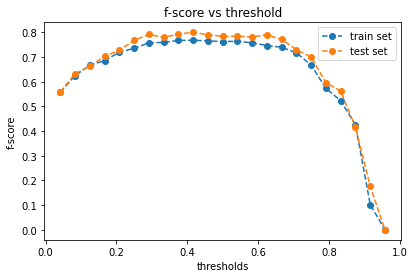

In [18]:
fig, ax = plt.subplots(figsize=[4 * 1.6, 4])
_ = plt.plot(thresholds, fscores_train, "--o", label="train set")
_ = plt.plot(thresholds, fscores_test, "--o", label="test set")
_ = plt.title("f-score vs threshold")
_ = plt.xlabel("thresholds")
_ = plt.ylabel("f-score")
_ = plt.legend()

## production pipeline & model

In [19]:
prod_pipe = copy.deepcopy(search.best_estimator_)
_ = prod_pipe.steps.pop(-1)
model_pd = copy.deepcopy(search.best_estimator_.steps[-1][1])

In [20]:
X_train_prepro_np = prod_pipe.transform_numpy(X_train.copy().to_numpy())
y_train_np = y_train.to_numpy()

xgb_booster = XGBBoosterBuilder.train(
    model=model_pd,
    X_train=X_train_prepro_np,
    y_train=y_train.to_numpy(),
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain="gcc",
    libpath="./models/treelite_xgb_titanic.so",
    params={"parallel_comp": 4},
    verbose=True,
)
model_prod = treelite_runtime.Predictor(
    "./models/treelite_xgb_titanic.so", verbose=False
)

[17:37:40] ../src/compiler/ast_native.cc:45: Using ASTNativeCompiler
[17:37:40] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 4 translation units.
[17:37:40] ../src/c_api/c_api.cc:121: Code generation finished. Writing code to files...
[17:37:40] ../src/c_api/c_api.cc:126: Writing file recipe.json...
[17:37:40] ../src/c_api/c_api.cc:126: Writing file tu3.c...
[17:37:40] ../src/c_api/c_api.cc:126: Writing file tu2.c...
[17:37:40] ../src/c_api/c_api.cc:126: Writing file tu1.c...
[17:37:40] ../src/c_api/c_api.cc:126: Writing file tu0.c...
[17:37:40] ../src/c_api/c_api.cc:126: Writing file header.h...
[17:37:40] ../src/c_api/c_api.cc:126: Writing file main.c...
[17:37:40] /Users/cpoli/gators38/lib/python3.8/site-packages/treelite/contrib/util.py:105: Compiling sources files in directory ./models/tmphtlwe8y1 into object files (*.o)...
[17:37:40] /Users/cpoli/gators38/lib/python3.8/site-packages/treelite/contrib/util.py:134: Generating dynam

### check if Pandas & Treelite predictions match

In [21]:
X_test_np = X_test.to_numpy()
y_pred_pd = model_pd.predict_proba(prod_pipe.transform(X_test.copy()))[:, 1]
y_pred_tl = model_prod.predict(
    treelite_runtime.DMatrix(prod_pipe.transform_numpy(X_test_np.copy()))
)
assert np.allclose(y_pred_pd, y_pred_tl)

## per-sample bechmarking

### pipeline only

In [22]:
x = X_test.iloc[[0]]
x_np = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(x_np.copy())

86.1 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
82.8 µs ± 2.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [23]:
speedup = 1e3 * float(str(stats_pd).split(" ")[0]) / float(str(stats_np).split(" ")[0])
f"Speed-up Pandas VS Numpy x{round(speedup)}"

'Speed-up Pandas VS Numpy x1040'

### pipeline & model

In [24]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [25]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_tl = %timeit -o  model_prod.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(x_np.copy())))

100 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
132 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
speedup = 1e3 * float(str(stats_pd).split(" ")[0]) / float(str(stats_tl).split(" ")[0])
f"Speed-up Pandas VS Numpy&Treelite x{round(speedup)}"

'Speed-up Pandas VS Numpy&Treelite x758'